In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from tbats import BATS, TBATS

%matplotlib inline

# Cuidado al usar Prophet. De-registra los convertores de pandas para matplotlib, ocasionando bugs.
from fbprophet import Prophet 

In [232]:
pd.plotting.register_matplotlib_converters() # Volvemos a registrar los convertores.
plt.rcParams['figure.figsize'] = [16, 4]

### Carga y limpieza de datos

In [233]:
# Cargamos los datos
data_hourly = pd.read_excel("./data/datos.xlsx", sheet_name="Hoja2")
data_hourly.head(10)

,Fecha,Hora UTC,Temp. (ºC),H.Rel (%),Presion/ Geopot.,Dir. vi.,Vel. vi. (Km/h),Nub.,Nubes bajas,Nubes medias,Nubes altas,Prec. (mm),T. max (ºC),T. min (ºC),Situacion
0,01/04/2019,23Z,19.3,86%,1013.2 Hpa,20º (N),11.2,2/8,-,1/8 AC,CI,-,-,-,Algunas nubes
1,01/04/2019,22Z,21.0,77%,1013.0 Hpa,20º (N),13.0,3/8,-,2/8 AC,CI,-,-,-,Nubes dispersas
2,01/04/2019,21Z,25.2,58%,1013.5 Hpa,360º (N),14.8,5/8,-,4/8 AC,CI,-,-,-,Nuboso
3,01/04/2019,20Z,27.0,48%,1013.4 Hpa,360º (N),18.4,5/8,-,4/8 AC,CI,-,-,-,Nuboso
4,01/04/2019,19Z,26.6,47%,1013.5 Hpa,20º (N),18.4,4/8,-,4/8 AC,-,-,-,-,Nubes dispersas
5,01/04/2019,18Z,27.2,40%,1013.8 Hpa,360º (N),20.5,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
6,01/04/2019,17Z,27.0,45%,1014.6 Hpa,360º (N),22.3,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
7,01/04/2019,16Z,26.2,47%,1015.6 Hpa,360º (N),18.4,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
8,01/04/2019,15Z,24.7,50%,1016.0 Hpa,360º (N),14.8,1/8,-,1/8 AC,-,-,-,-,Algunas nubes
9,01/04/2019,14Z,22.8,56%,1016.5 Hpa,360º (N),16.6,1/8,-,1/8 AC,-,-,-,-,Algunas nubes


Comenzamos por combinar las columnas de fecha y hora para crear un indice en formato datetime y acomodamos los nombres de las columnas para acceso más conveniente.

In [234]:
data_hourly["Hora UTC"] = data_hourly["Hora UTC"].map(lambda x: x[:-1])
data_hourly["fecha"] = pd.to_datetime(data_hourly["Fecha"] + " " + data_hourly["Hora UTC"], format="%d/%m/%Y %H")
data_hourly = data_hourly.set_index("fecha").sort_index()
data_hourly = data_hourly.drop(labels=["Hora UTC", "Fecha"], axis=1)
data_hourly.columns = ["temp", "hum", "presion", "dir", "vel", "nub", "n_bajas", "n_medias", "n_altas", "prec", "t_max", "t_min", "situacion"]
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85%,1016.3 Hpa,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93%,1016.7 Hpa,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95%,1016.7 Hpa,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96%,1016.7 Hpa,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95%,1016.3 Hpa,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


Revisamos los valores faltantes.

In [235]:
data_hourly.isna().sum()

temp          4
hum           6
presion       0
dir           0
vel          10
nub           0
n_bajas       0
n_medias      0
n_altas       0
prec          0
t_max         0
t_min         0
situacion     0
dtype: int64

Ahora vamos a transformar algunas columnas. Para procesarlas vamos a tener que asegurarnos de que sigan un formato coherente. Nos fijamos qué observaciones siguen un patrón diferente y vemos si las descartamos o podemos arreglarlas. Luego aplicamos la transformación.

#### Humedad

In [236]:
# Observaciones donde la columna humedad no sigue el formato esperado.
mask = ~data_hourly.hum.str.match("^\d{,3}\%$", na=False)
data_hourly[mask]

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-05-26 15:00:00,10.2,NaN,1011.2 Hpa,320º (NW),9.3,8/8,6/8 SC,AC,N/D,-,-,-,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5 Hpa,calma,NaN,5/8,-,-,CI,-,-,-,"Nuboso, niebla"
2019-06-22 12:00:00,7.8,NaN,1019.3 Hpa,230º (SW),7.4,6/8,-,-,CI,-,10.5,24.0,"Nuboso, neblina"
2019-06-27 23:00:00,4.1,NaN,1010.5 Hpa,360º (N ),9.3,8/8,-,5/8 AC,CI,-,-,-,Cubierto
2019-07-09 17:00:00,4.6,NaN,1020.9 Hpa,320º (NW),5.6,4/8,-,-,CI,-,-,-,Nubes dispersas
2019-08-06 07:00:00,3.4,NaN,1013.8 Hpa,340º (N ),11.1,0/8,-,-,-,-,-,-,Despejado


La columna de humedad no tiene problemas, solo datos faltantes, así que la transformamos a numérico.

In [237]:
data_hourly.hum = pd.to_numeric(data_hourly.hum.str.strip("%"))
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3 Hpa,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7 Hpa,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7 Hpa,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7 Hpa,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3 Hpa,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


#### Presion

In [238]:
# Observaciones donde la presión no sigue el patrón que debería
mask = ~data_hourly.presion.str.match("^\s*\d{3,4}[.]\d\s*Hpa\s*$", na=False)
data_hourly[mask]

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-06-23 00:00:00,17.6,62.0,-,320º (NW),3.7,7/8,-,-,CI,-,19.1,8.2,"Nuboso, neblina"
2019-06-28 10:00:00,4.4,89.0,-,180º (S),9.4,6/8,-,1/8 AC,CI/CS,-,-,-,Nuboso
2019-07-16 01:00:00,2.8,86.0,234 m (1000 Hpa),200º (S),5.4,0/8,-,-,-,-,-,-,Despejado
2019-07-25 13:00:00,3.0,62.0,-,110º (E ),7.4,7/8,-,2/8 AC,CI,-,-,-,Nuboso
2019-09-03 05:00:00,23.7,17.0,-,230º (SW),18.5,0/8,-,-,-,-,-,-,Despejado


Tenemos un valor con un formato diferente al resto y datos faltantes. Solo nos interesa el valor numérico, así que lo extraemos y asignamos NA a las observaciones problemáticas.

In [239]:
ext = data_hourly.presion.str.extract("^\s*(\d{3,4}[.]\d)\s*Hpa\s*$") # Extrae y asigna NA a las que no coinciden con el patrón.
data_hourly.presion = pd.to_numeric(ext[0])
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,070º (E ),14.8,6/8,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,70º (E),9.4,4/8,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,70º (E),3.6,0/8,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,180º (S),5.4,0/8,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,110º (E),7.6,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


#### Dirección del viento

In [240]:
# Observaciones de dirección con formato diferente al esperado.
mask = ~data_hourly.dir.str.match("^\s*\d{1,3}.\s*[(]\s*[NESW]{,2}\s*[)]\s*$", na=False)
data_hourly[mask]

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 06:00:00,15.6,96.0,1015.8,calma,NaN,5/8,-,2/8 AC,CI,-,-,-,"Nuboso, neblina"
2019-06-01 06:00:00,7.1,93.0,1016.8,calma,NaN,8/8,-,8/8 AC,N/D,-,-,-,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5,calma,NaN,5/8,-,-,CI,-,-,-,"Nuboso, niebla"
2019-06-22 00:00:00,9.9,93.0,1019.5,calma,NaN,7/8,-,4/8 AC,CI,-,14.2,3.2,Nuboso
2019-07-07 12:00:00,-0.4,95.0,1026.9,calma,NaN,5/8,-,-,CI,-,2.0,-4.8,Nuboso
2019-07-31 09:00:00,3.9,100.0,1010.3,calma,NaN,2/8,-,-,CI,-,-,-,"Algunas nubes, niebla"
2019-08-10 12:00:00,-0.4,95.0,1017.1,calma,NaN,0/8,-,-,-,-,1.4,-4.6,Despejado
2019-08-22 12:00:00,4.8,93.0,1030.6,calma,NaN,8/8,-,8/8 AC,N/D,0.2(24h),5.0,2.5,Cubierto
2019-08-26 12:00:00,9.4,93.0,1018.7,calma,NaN,0/8,-,-,-,-,9.6,3.6,"Despejado, niebla"


Nos quedamos solo con el punto cardinal y le asignamos "-" a la dirección en aquellas observaciones que corresponden a días sin viento, como también cero a la velocidad.

In [241]:
ext = data_hourly.dir.str.extract("^\s*\d{1,3}.\s*[(]\s*([NESW]{,2})\s*[)]\s*$")
data_hourly.loc[data_hourly.dir != "calma", "dir"] = ext[0]
data_hourly.loc[data_hourly.dir == "calma", ["dir", "vel"]] = ["-", 0]

Comprobamos si los días con velocidad cero coinciden con aquellos días con dirección nula.

In [242]:
(data_hourly.vel == 0).equals(data_hourly.dir == "-")

False

No coinciden, así que lo revisamos mejor.

In [243]:
data_hourly[(data_hourly.vel == 0) != (data_hourly.dir == "-")].head(10)

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 05:00:00,16.0,96.0,1016.6,N,0.0,4/8,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"
2019-04-02 02:00:00,17.2,93.0,1012.8,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-03 05:00:00,9.0,96.0,1014.8,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-04 00:00:00,12.9,73.0,1007.1,N,0.0,0/8,-,-,-,-,23.4,11.9,Despejado
2019-04-05 21:00:00,18.2,47.0,1020.2,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-05 22:00:00,14.1,67.0,1020.7,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-06 00:00:00,8.6,87.0,1021.6,N,0.0,0/8,-,-,-,-,20.0,8.6,Despejado
2019-04-06 01:00:00,7.7,87.0,1022.1,N,0.0,0/8,-,-,-,-,-,-,Despejado
2019-04-06 02:00:00,6.6,88.0,1022.2,N,0.0,0/8,-,-,-,-,-,-,Despejado


Parece que en casi todos los días con velocidad cero la dirección asignada fue N(0°).

In [244]:
data_hourly[data_hourly.vel == 0].dir.unique()

array(['N', '-'], dtype=object)

En efecto, ese es el caso, por lo que procedemos a reemplazar todos esos N con "-".

In [245]:
data_hourly.loc[data_hourly.vel == 0, "dir"] = "-"

#### Nubosidad

In [246]:
data_hourly.nub.unique()

array(['6/8 ', '4/8', '0/8', '5/8 ', '7/8', '6/8', '3/8', '5/8', '1/8',
       '2/8', '2/8 ', 'N/D', '8/8', '8/8 ', '0/8 ', '7/8 ', '3/8 ',
       '1/8 ', '4/8 ', 'N/D '], dtype=object)

Hay algunos espacios al final y valores no disponibles. Ya sabemos que la humedad está medida en octas, por lo que no quedamos con el numerador solamente y asignamos -1 a los valores "N/D" y pasamos a numérico.

In [247]:
#data_hourly.nub = data_hourly.nub.str.strip()
data_hourly.nub = data_hourly.nub.apply(lambda x: x[0])
data_hourly.loc[data_hourly.nub == "N", "nub"] = -1

In [248]:
data_hourly.nub = pd.to_numeric(data_hourly.nub)

In [249]:
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6,-,2/8 AC,CI,-,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4,-,-,CI/CS,-,-,-,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0,-,-,-,-,-,-,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0,-,-,-,-,-,-,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4,-,-,CI/CS,-,-,-,"Nubes dispersas, neblina"


In [250]:
data_hourly.nub.unique()

array([ 6,  4,  0,  5,  7,  3,  1,  2, -1,  8], dtype=int64)

Una inspección a las observaciones con valores -1 de nubosidad resulta ser reveladora. Ese valor corresponde a días de niebla.

In [251]:
data_hourly[data_hourly.nub == -1].head(10)

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-02 10:00:00,17.9,98.0,1010.7,NW,11.2,-1,-,-,-,-,-,-,Niebla
2019-04-02 11:00:00,17.6,100.0,1010.9,NW,11.2,-1,-,-,-,-,-,-,Niebla
2019-04-02 12:00:00,18.0,100.0,1010.6,N,11.2,-1,-,-,-,-,19.2,15.0,Niebla
2019-04-02 13:00:00,19.6,100.0,1010.6,NW,13.0,-1,-,-,-,-,-,-,Niebla
2019-04-04 08:00:00,11.9,100.0,1001.0,N,3.6,-1,-,-,-,-,-,-,Niebla
2019-04-04 09:00:00,12.6,100.0,1000.9,N,7.6,-1,-,-,-,-,-,-,Niebla
2019-04-04 10:00:00,13.2,98.0,1000.6,E,7.6,-1,-,-,-,-,-,-,Niebla
2019-05-04 05:00:00,10.7,96.0,1015.4,E,16.6,-1,-,-,-,-,-,-,Niebla
2019-05-04 06:00:00,11.9,98.0,1016.3,E,14.8,-1,-,-,-,-,-,-,Niebla


In [252]:
data_hourly[data_hourly.nub == -1].situacion.unique()

array(['Niebla', 'niebla'], dtype=object)

#### Precipitaciones

In [253]:
data_hourly.prec.unique()

array(['-', '17.0(24h)', '11.0(6h)', '2.0(6h)', '12.0(24h)', '20.0(6h)',
       '0.6(6h)', '21.0(24h)', '4.0(24h)', '6.0(6h)', '3.0(6h)',
       '8.0(24h)', 'Ip(24h)', 'Ip(6h)', '1.0(6h)', '18.0(6h)',
       '22.0(24h)', '0.2(6h)', '0.7(6h)', '0.9(24h)', '3.0(24h)',
       '23.0(6h)', '5.0(6h)', '28.0(24h)', '45.0(24h)', '0.5(6h)',
       '0.6(24h)', '35.0(6h)', '39.0(24h)', '13.0(24h)', '27.0(6h)',
       '13.0(6h)', '56.0(24h)', '0.4(6h)', ' 0.8(6h) ', '2.0(24h)',
       '0.3(6h)', '62.0(12h)', ' 0.2(24h)', '5.0(24h)'], dtype=object)

In [254]:
data_hourly.loc[~data_hourly.prec.str.match("\s*(\d{,2}.\d).*", na=False), "prec"].unique()

array(['-', 'Ip(24h)', 'Ip(6h)'], dtype=object)

La columna de precipitacion contiene la combinación de dos valores: la cantidad en mm y lo que parece ser una aproximación al número de horas que ha estado precipitando. También hay un valor denominado "Ip" que corresponde a precipitaciones inapreciables. Lo que vamos a hacer es quedarnos solo con la información numérica de la precipitacion en mm y descartar todo lo demás. A las celdas con "-" y "Ip" le vamos a asignar 0.

In [255]:
mask = (data_hourly.prec == "Ip(24h)") | (data_hourly.prec == "Ip(6h)") | (data_hourly.prec == "-")
data_hourly.loc[mask, "prec"] = 0.0

In [256]:
extr = data_hourly.prec.str.extract("\s*(\d{,2}.\d).*")[0]

In [257]:
data_hourly.loc[~extr.isna(), "prec"] = extr.dropna()

In [258]:
data_hourly.prec = pd.to_numeric(data_hourly.prec)

In [259]:
data_hourly.prec.unique()

array([ 0. , 17. , 11. ,  2. , 12. , 20. ,  0.6, 21. ,  4. ,  6. ,  3. ,
        8. ,  1. , 18. , 22. ,  0.2,  0.7,  0.9, 23. ,  5. , 28. , 45. ,
        0.5, 35. , 39. , 13. , 27. , 56. ,  0.4,  0.8,  0.3, 62. ])

#### Temperaturas máximas y mínimas

In [260]:
data_hourly.loc[:, ["temp", "t_max", "t_min"]].head(25)

,temp,t_max,t_min
fecha,,,
2019-04-01 00:00:00,20.1,28.9,18.7
2019-04-01 01:00:00,19.2,-,-
2019-04-01 02:00:00,18.5,-,-
2019-04-01 03:00:00,15.2,-,-
2019-04-01 04:00:00,16.2,-,-
2019-04-01 05:00:00,16.0,-,-
2019-04-01 06:00:00,15.6,-,-
2019-04-01 07:00:00,15.2,-,-
2019-04-01 08:00:00,15.0,-,-


Las temperaturas máximas y mínimas se anotan al final del período correspondiente. Por lo tanto podemos reemplazar todos los "-" con NA y después realizar un backfill.

In [261]:
data_hourly.loc[data_hourly.t_max == "-", "t_max"] = np.nan
data_hourly.loc[data_hourly.t_min == "-", "t_min"] = np.nan

In [262]:
data_hourly.t_max = pd.to_numeric(data_hourly.t_max)
data_hourly.t_min = pd.to_numeric(data_hourly.t_min)

In [263]:
data_hourly.t_max = data_hourly.t_max.fillna(method="bfill")
data_hourly.t_min = data_hourly.t_min.fillna(method="bfill")

In [264]:
data_hourly.head()

,temp,hum,presion,dir,vel,nub,n_bajas,n_medias,n_altas,prec,t_max,t_min,situacion
fecha,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6,-,2/8 AC,CI,0.0,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4,-,-,CI/CS,0.0,20.1,12.5,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0,-,-,-,0.0,20.1,12.5,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0,-,-,-,0.0,20.1,12.5,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4,-,-,CI/CS,0.0,20.1,12.5,"Nubes dispersas, neblina"


#### Nubes bajas, medias y altas

Por último, las columnas con los datos de nubosidad baja, media y alta no nos interesan, así que las tiramos.

In [265]:
data_hourly = data_hourly.drop(columns=["n_bajas", "n_medias", "n_altas"])

In [266]:
data_hourly.head()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6,0.0,28.9,18.7,Nuboso
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4,0.0,20.1,12.5,Nubes dispersas
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0,0.0,20.1,12.5,Despejado
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0,0.0,20.1,12.5,"Despejado, neblina"
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4,0.0,20.1,12.5,"Nubes dispersas, neblina"


### Análisis y datos faltantes

Verificamos qué columnas tienen datos faltantes.

In [267]:
data_hourly.isna().sum()

temp         4
hum          6
presion      5
dir          0
vel          0
nub          0
prec         0
t_max        7
t_min        7
situacion    0
dtype: int64

Revisamos los valores faltantes de temperatura.

In [268]:
data_hourly[data_hourly.temp.isna()]

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-06-22 21:00:00,NaN,0.0,1017.4,N,57.4,1,0.0,19.1,8.2,Algunas nubes
2019-06-23 10:00:00,NaN,0.0,1012.4,N,122.3,1,0.0,10.4,4.0,Algunas nubes
2019-07-26 21:00:00,NaN,0.0,1020.8,S,11.1,5,0.0,14.0,5.2,Nuboso
2019-08-30 00:00:00,NaN,0.0,1015.9,N,113.0,1,0.0,16.0,6.0,Algunas nubes


Esas observaciones tienen valores nulos en la columna de humedad. Nos fijamos si las observaciones con humedad 0 son las mismas.

In [269]:
data_hourly[data_hourly.temp.isna()].equals(data_hourly[data_hourly.hum == 0])

True

Claramente los valores de humedad cero en realidad corresponden a mediciones faltantes, así que los representamos como tal.

In [270]:
data_hourly.loc[data_hourly.hum == 0, "hum"] = np.nan

Ahora revisamos los datos faltantes en la columna de humedad.

In [271]:
data_hourly[data_hourly.hum.isna()]

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion
fecha,,,,,,,,,,
2019-05-26 15:00:00,10.2,NaN,1011.2,NW,9.3,8,0.0,10.2,8.2,Cubierto
2019-06-21 11:00:00,3.4,NaN,1019.5,-,0.0,5,0.0,7.3,2.2,"Nuboso, niebla"
2019-06-22 12:00:00,7.8,NaN,1019.3,SW,7.4,6,0.0,10.5,24.0,"Nuboso, neblina"
2019-06-22 21:00:00,NaN,NaN,1017.4,N,57.4,1,0.0,19.1,8.2,Algunas nubes
2019-06-23 10:00:00,NaN,NaN,1012.4,N,122.3,1,0.0,10.4,4.0,Algunas nubes
2019-06-27 23:00:00,4.1,NaN,1010.5,N,9.3,8,0.0,11.6,3.9,Cubierto
2019-07-09 17:00:00,4.6,NaN,1020.9,NW,5.6,4,0.0,16.2,5.3,Nubes dispersas
2019-07-26 21:00:00,NaN,NaN,1020.8,S,11.1,5,0.0,14.0,5.2,Nuboso
2019-08-06 07:00:00,3.4,NaN,1013.8,N,11.1,0,0.0,10.0,3.0,Despejado


Revisamos si hay fechas faltantes.

In [272]:
start = data_hourly.index[0]
end = data_hourly.index[-1]
missing_dates = pd.date_range(start=start, end=end, freq="H").difference(data_hourly.index)
print("Hay {} valores faltantes en las observaciones.".format(len(missing_dates)))
print("Los días y horas que faltan son:")
missing_dates

Hay 73 valores faltantes en las observaciones.
Los días y horas que faltan son:


DatetimeIndex(['2019-04-02 04:00:00', '2019-04-25 07:00:00',
               '2019-05-22 07:00:00', '2019-05-23 02:00:00',
               '2019-05-23 04:00:00', '2019-05-23 08:00:00',
               '2019-05-27 17:00:00', '2019-06-13 13:00:00',
               '2019-06-16 07:00:00', '2019-06-16 10:00:00',
               '2019-06-16 11:00:00', '2019-06-16 12:00:00',
               '2019-06-16 13:00:00', '2019-06-16 14:00:00',
               '2019-06-16 15:00:00', '2019-06-16 16:00:00',
               '2019-06-16 17:00:00', '2019-06-16 18:00:00',
               '2019-06-16 19:00:00', '2019-06-16 20:00:00',
               '2019-06-16 21:00:00', '2019-06-16 22:00:00',
               '2019-06-16 23:00:00', '2019-06-17 00:00:00',
               '2019-06-17 01:00:00', '2019-06-17 02:00:00',
               '2019-06-17 03:00:00', '2019-06-17 04:00:00',
               '2019-06-17 05:00:00', '2019-06-17 06:00:00',
               '2019-06-17 07:00:00', '2019-06-17 08:00:00',
               '2019-06-

Le decimos a pandas que ponga los datos en frecuencia horaria, creando NA para los valores que faltan.

In [273]:
data_hourly = data_hourly.asfreq("H")
data_hourly.isna().sum()

temp         77
hum          83
presion      78
dir          73
vel          73
nub          73
prec         73
t_max        80
t_min        80
situacion    73
dtype: int64

Creamos columnas para guardar la hora, día, semana y mes. Esto es por conveniencia. También agregamos una columna que nos dice si la fila corresponde a una de las fechas faltantes.

In [274]:
index = data_hourly.index
data_hourly["hora"] = index.hour
data_hourly["dia_mes"] = index.day
data_hourly["dia_año"] = index.dayofyear 
data_hourly["semana"] = index.week
data_hourly["mes"] = index.month
data_hourly["faltante"] = data_hourly.index.map(lambda x: x in missing_dates)
data_hourly.head()

,temp,hum,presion,dir,vel,nub,prec,t_max,t_min,situacion,hora,dia_mes,dia_año,semana,mes,faltante
fecha,,,,,,,,,,,,,,,,
2019-04-01 00:00:00,20.1,85.0,1016.3,E,14.8,6.0,0.0,28.9,18.7,Nuboso,0,1,91,14,4,False
2019-04-01 01:00:00,19.2,93.0,1016.7,E,9.4,4.0,0.0,20.1,12.5,Nubes dispersas,1,1,91,14,4,False
2019-04-01 02:00:00,18.5,95.0,1016.7,E,3.6,0.0,0.0,20.1,12.5,Despejado,2,1,91,14,4,False
2019-04-01 03:00:00,15.2,96.0,1016.7,S,5.4,0.0,0.0,20.1,12.5,"Despejado, neblina",3,1,91,14,4,False
2019-04-01 04:00:00,16.2,95.0,1016.3,E,7.6,4.0,0.0,20.1,12.5,"Nubes dispersas, neblina",4,1,91,14,4,False


Podemos crear una gráfica para ver como se distribuyen las fechas faltantes.

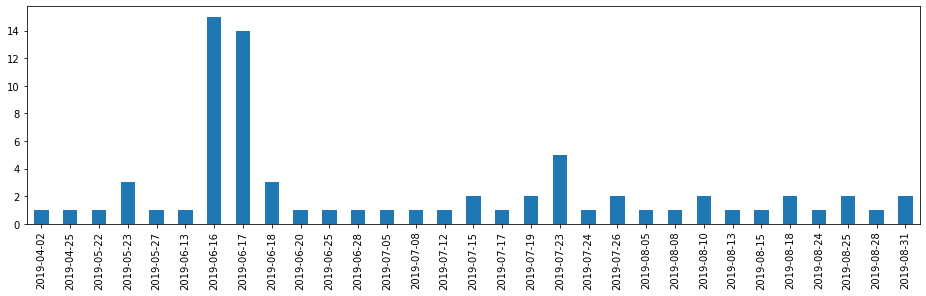

In [275]:
tmp = data_hourly.groupby(data_hourly.index.date)["faltante"].sum()
tmp = tmp[tmp != 0]
tmp.plot(kind="bar")

Los días 2019-06-16 y 2019-06-17 son los que registran un mayor número de valores faltantes. Si graficamos algunas de las series temporales...

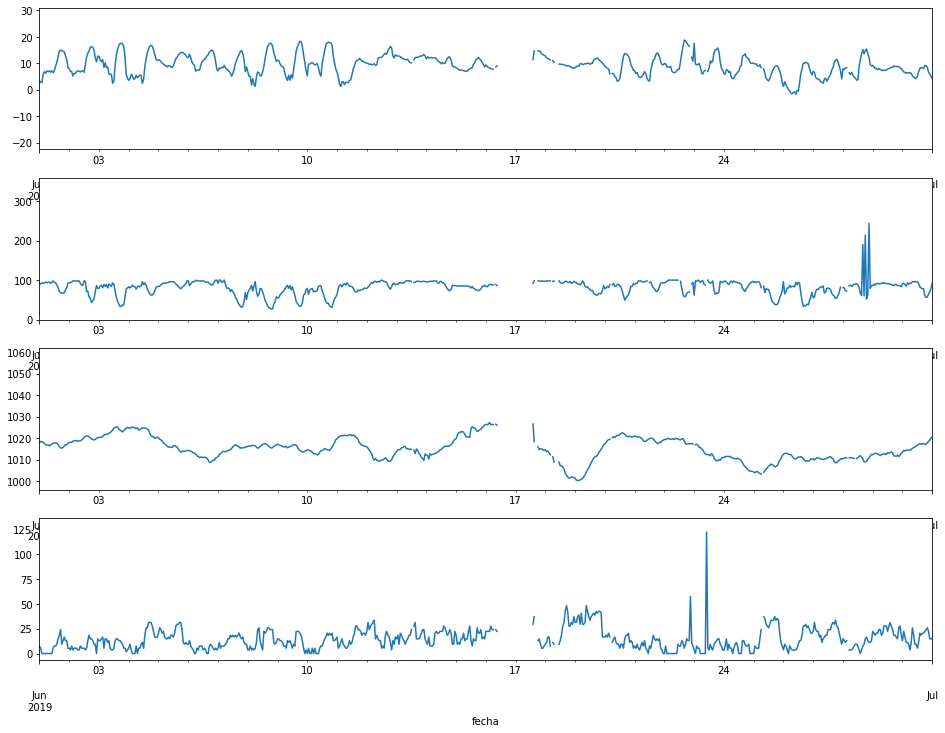

In [276]:
f, ax = plt.subplots(4, 1, figsize=(16,12))
data_hourly.temp.plot(xlim=("2019-06", "2019-07"), ax=ax[0])
data_hourly.hum.plot(xlim=("2019-06", "2019-07"), ax=ax[1])
data_hourly.presion.plot(xlim=("2019-06", "2019-07"), ax=ax[2])
data_hourly.vel.plot(xlim=("2019-06", "2019-07"), ax=ax[3])

...queda claro que esos valores faltantes son consecutivos. También parece que el intervalo entre el día 11 y 20 de junio presenta un patrón diferente al resto del mes. En particular, las oscilaciones diarias de temperatura y humedad disminuyen notablemente. Eso es extraño, y sumado a la gran cantidad de observaciones faltantes, podría indicar un problema con las mediciones de ese período.

Vamos a revisar las series de temperatura y humedad para cada uno de los meses por separado.

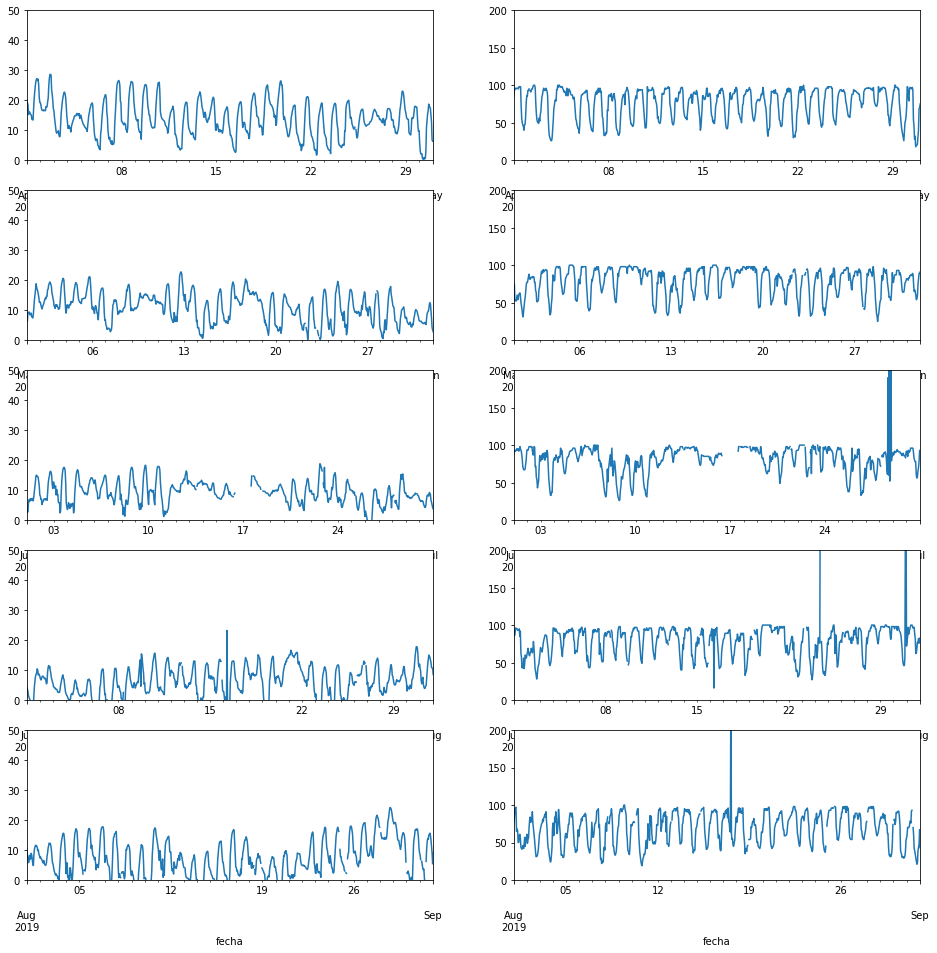

In [277]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,16))
dates = pd.date_range(start="2019-04", end="2019-09", freq="MS")
for k in range(len(dates)-1):
    data_hourly.temp.plot(kind="line", xlim=(dates[k], dates[k+1]), ax=ax[k,0], ylim=(0,50));
    data_hourly.hum.plot(kind="line", xlim=(dates[k], dates[k+1]), ax=ax[k,1], ylim=(0,200));

Efectivamente, la serie de junio presenta un patron inusual durante ese intervalo, sugiriendo algún tipo de problema con esos valores. Lo que vamos a hacer es replicar el patrón de los días anteriores para reemplazar esos datos.

In [278]:
columns = ["temp", "hum", "presion"]
data_hourly.loc["2019-06-11":"2019-06-20", columns] = data_hourly.loc["2019-06-02":"2019-06-11", columns].to_numpy()
data_hourly.loc["2019-06-16":"2019-06-17", "vel"] = data_hourly.loc["2019-06-14":"2019-06-15", "vel"].to_numpy()

Así es como quedan las series corregidas.

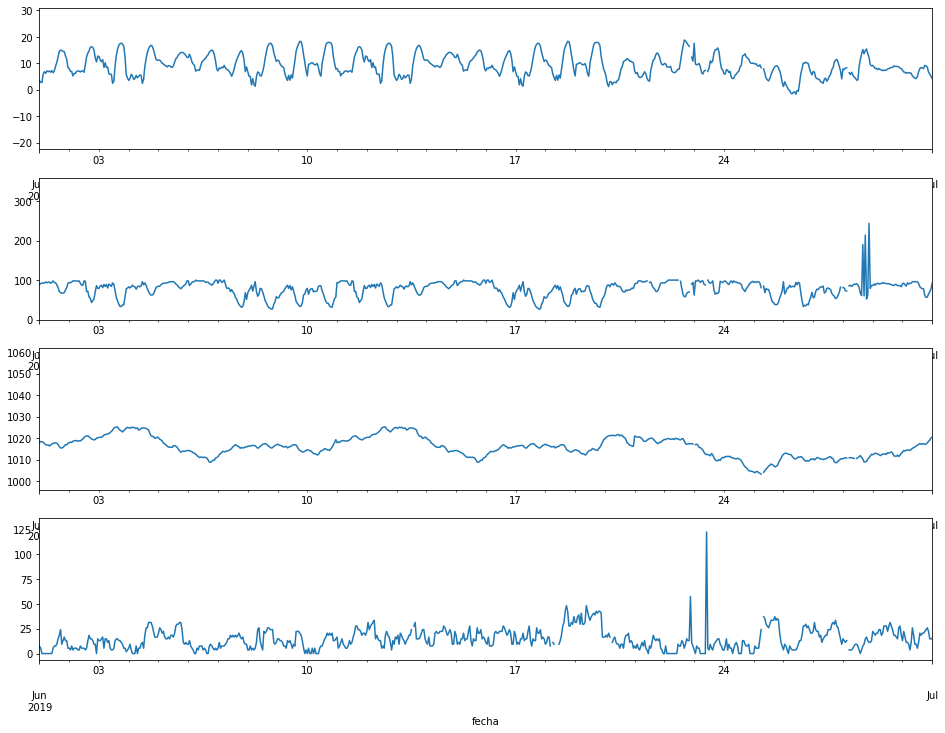

In [279]:
f, ax = plt.subplots(4, 1, figsize=(16,12))
data_hourly.temp.plot(xlim=("2019-06", "2019-07"), ax=ax[0])
data_hourly.hum.plot(xlim=("2019-06", "2019-07"), ax=ax[1])
data_hourly.presion.plot(xlim=("2019-06", "2019-07"), ax=ax[2])
data_hourly.vel.plot(xlim=("2019-06", "2019-07"), ax=ax[3])

Los valores faltantes están dentros de valores razonables como para realizar una interpolación, eso es, no hay huecos demasiado grandes, como muestra la gráfica a continuación.

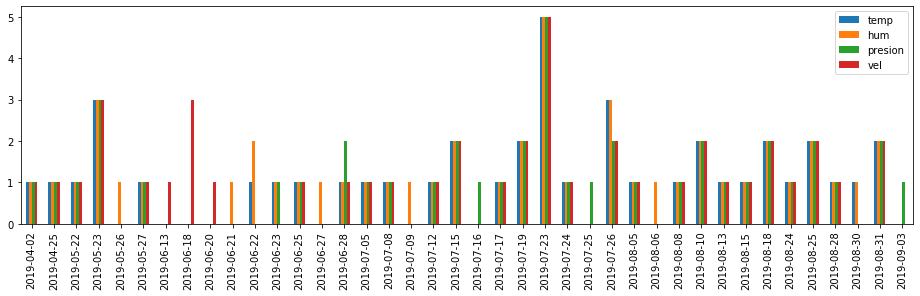

In [280]:
tmp = data_hourly[["temp","hum","presion","vel"]].apply(pd.isna).groupby(data_hourly.index.date).sum()
tmp[tmp != 0].dropna(how="all").plot(kind="bar")

Por lo que realizamos una interpolación lineal en las columnas de temperatura, humedad y presion.

In [281]:
data_hourly[["temp", "hum", "presion", "vel"]] = data_hourly[["temp", "hum", "presion", "vel"]].interpolate(method="linear")

In [282]:
data_hourly.isna().sum()

temp          0
hum           0
presion       0
dir          73
vel           0
nub          73
prec         73
t_max        80
t_min        80
situacion    73
hora          0
dia_mes       0
dia_año       0
semana        0
mes           0
faltante      0
dtype: int64

Extraemos la serie de temperaturas.

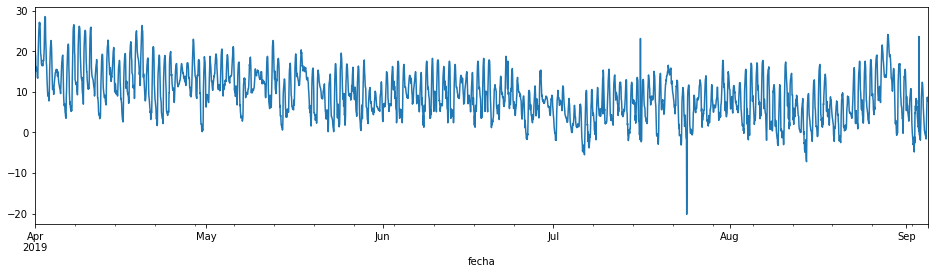

In [283]:
temp = data_hourly.temp.copy()
temp.plot(kind="line", figsize=(16,4))

En general se observa una tendencia descendente en las temperaturas, esperable por la transición de otoño a invierno, con un ascenso durante el final de agosto. También es claro el patrón de estacionalidad diario.

Durante el mes de julio se observan dos outliers, y uno más en septiembre.

A continuación revisamos los outliers de julio:

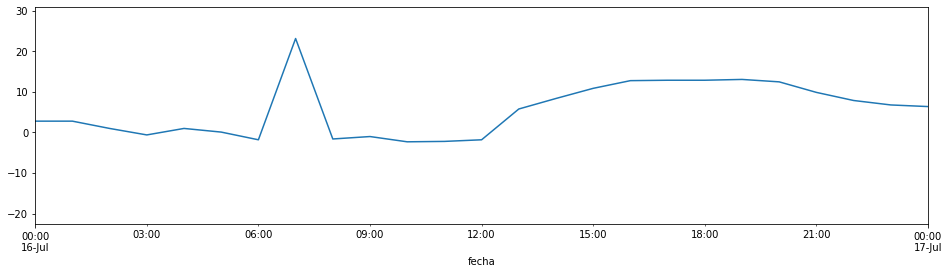

In [284]:
temp.plot(kind="line", xlim=("2019-07-16", "2019-07-17"));

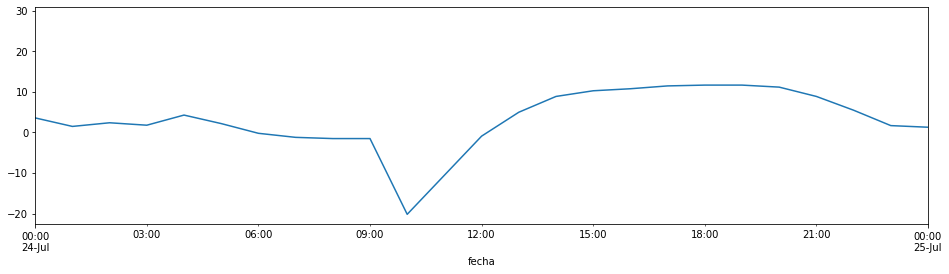

In [285]:
temp.plot(kind="line", xlim=("2019-07-24", "2019-07-25"));

Los outliers de julio son claramente el resultado de un error de entrada de datos o de medición.

Se observa lo mismo en septiembre:

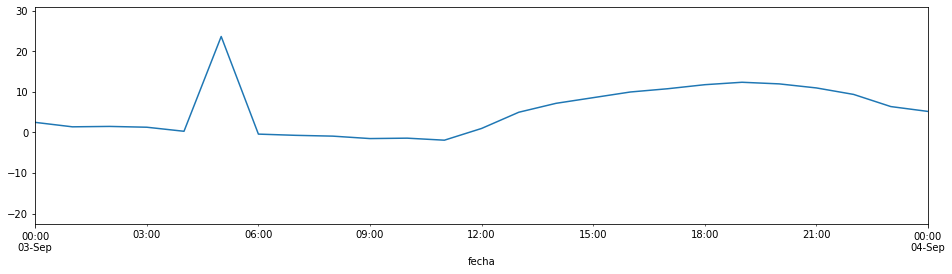

In [286]:
temp.plot(kind="line", xlim=("2019-09-03", "2019-09-04"));

Los catalogamos como NA, para interpolarlos más tarde.

In [287]:
temp.loc["2019-07-16 07:00:00"] = np.nan
temp.loc["2019-07-24 11:00:00"] = np.nan
temp.loc["2019-07-24 10:00:00"] = np.nan
temp.loc["2019-09-03 05:00:00"] = np.nan

Si revisamos cada mes por separado.

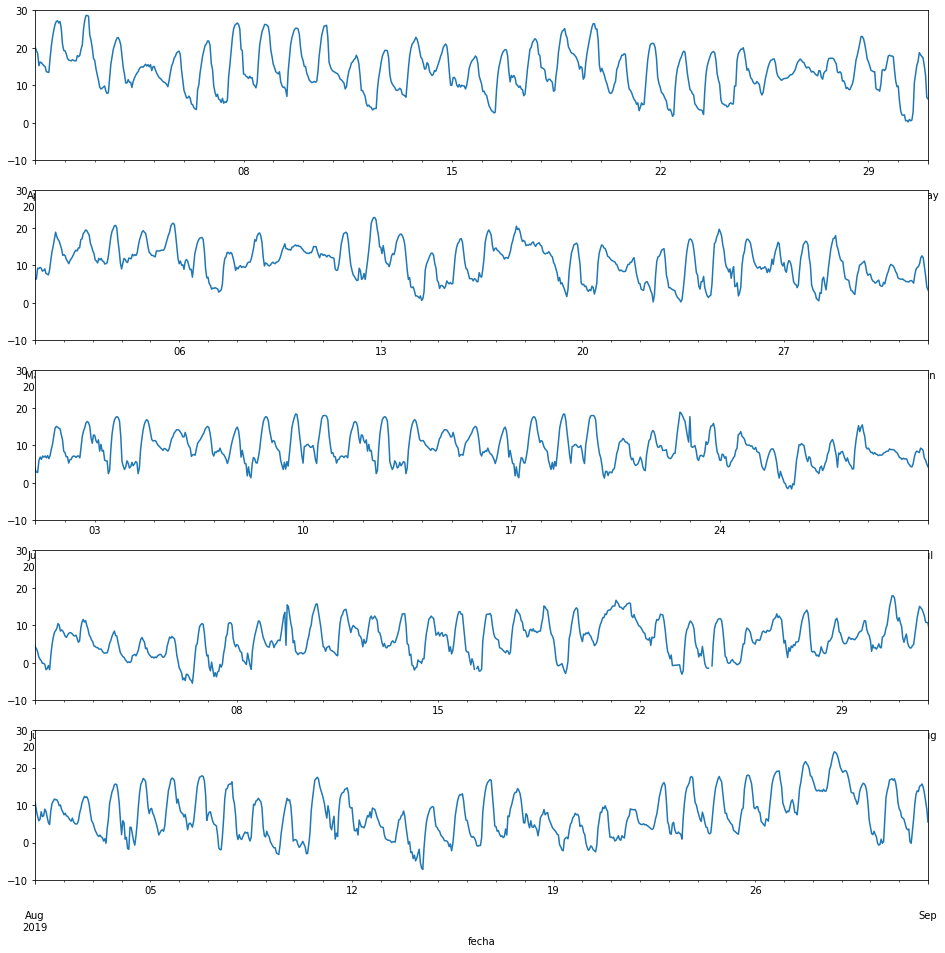

In [288]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(16,16))
dates = pd.date_range(start="2019-04", end="2019-09", freq="MS")
for k in range(len(dates)-1):
    temp.plot(kind="line", xlim=(dates[k], dates[k+1]), ax=ax[k], ylim=(-10,30));

Se observan algunas mediciones que no son outliers, pero son saltos repentinos, demasiado abruptos para ser cambios de temperatura razonables. Una de estos se encuentra entre el 9 y el 10 de julio, el otro el 23 de junio.

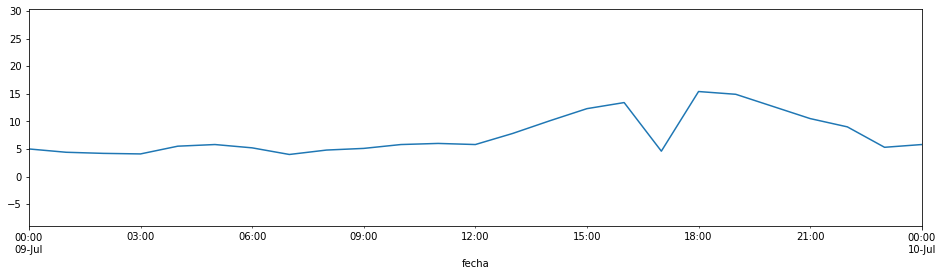

In [289]:
temp.plot(xlim=("2019-07-09", "2019-07-10"))

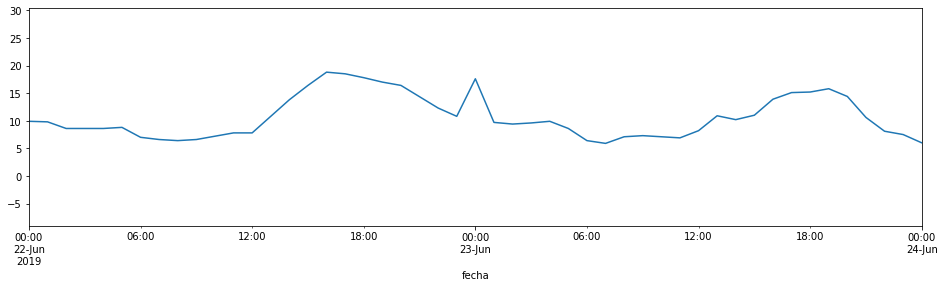

In [290]:
temp.plot(xlim=("2019-06-22", "2019-06-24"))

Los anulamos también.

In [291]:
temp.loc["2019-06-23 00:00:00"] = np.nan
temp.loc["2019-07-09 17:00:00"] = np.nan

Volvemos a interpolar las temperaturas.

In [292]:
temp = temp.interpolate(method="linear")

También podemos hacer un boxplot para ver como se distribuyen las temperaturas.

In [293]:
#sns.catplot(data=data_hourly, x="semana", y="temp", kind="box", aspect=2);

## Pronóstico

In [294]:
pot = pd.read_csv("./data/potencia.csv", parse_dates=["fecha"], index_col="fecha")

In [295]:
pot.head()

,potencia
fecha,
2019-05-30 12:45:00,975
2019-05-30 12:46:00,1003
2019-05-30 12:47:00,1007
2019-05-30 12:48:00,989
2019-05-30 12:49:00,800


In [296]:
pot = pot.rename(columns={"potencia":"pot"})

In [297]:
pot_h = pot.resample("H").mean()

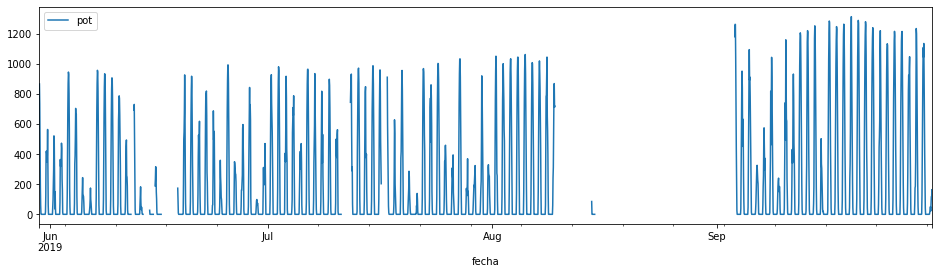

In [298]:
pot_h.plot()

In [299]:
pot_julio = pot_h.loc["2019-07-01":"2019-07-31"].copy()

In [300]:
pot_test = pot_h.loc["2019-08-01":"2019-08-07"].copy()
pot_test = pot_test.pot

In [301]:
pot_julio.loc[:,"dia"] = pot_julio.index.day
pot_julio.loc[:,"hora"] = pot_julio.index.hour

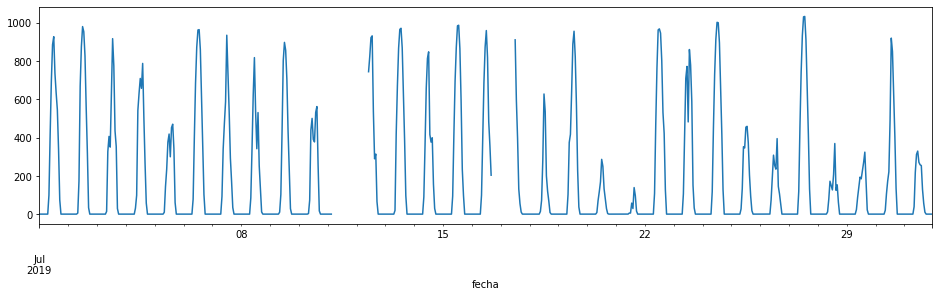

In [302]:
pot_julio.pot.plot()

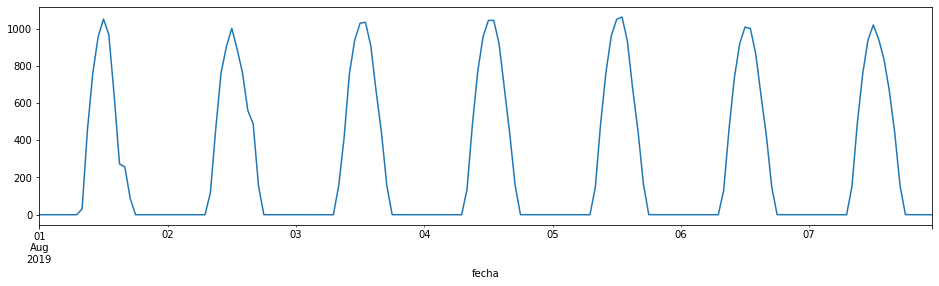

In [303]:
pot_test.plot()

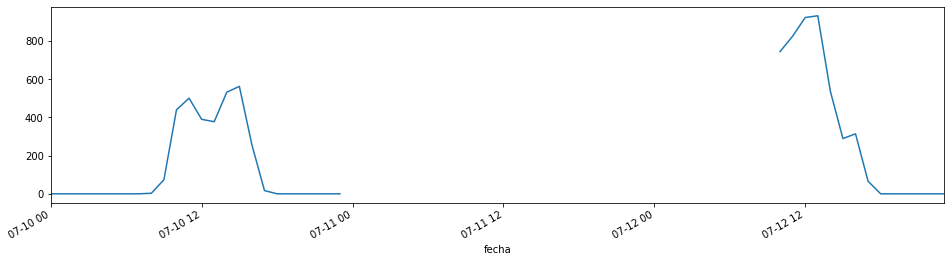

In [304]:
pot_julio.loc[pot_julio.dia.isin([10,12]), "pot"].plot()

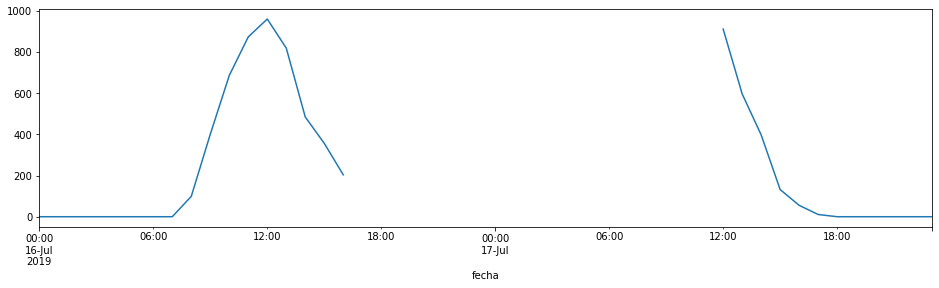

In [305]:
pot_julio.loc[pot_julio.dia.isin([16,17]), "pot"].plot()

In [306]:
values = pot_julio.loc[pot_julio.dia == 9, "pot"].to_numpy()
pot_julio.loc[pot_julio.dia == 11, "pot"] = values

In [307]:
pot_julio.loc[(pot_julio.dia == 12) & (pot_julio.hora.isin(range(0,8))), "pot"] = 0
pot_julio.loc[(pot_julio.dia == 17) & (pot_julio.hora.isin(range(0,8))), "pot"] = 0
pot_julio.loc[(pot_julio.dia == 16) & (pot_julio.hora.isin(range(18,24))), "pot"] = 0

In [308]:
pot_julio.loc[:, "pot"] = pot_julio.loc[:,"pot"].interpolate(method="spline", order=2)

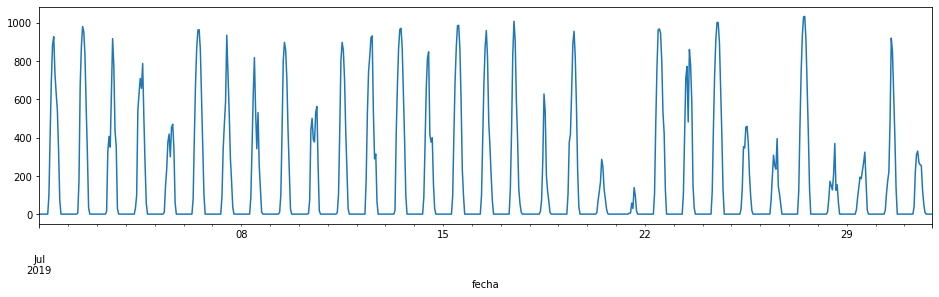

In [309]:
pot_julio.pot.plot()

In [310]:
pot_julio = pot_julio.pot

In [311]:
exog_julio = data_hourly.loc[data_hourly.mes == 7, ["temp", "hum", "presion", "vel", "nub"]].copy()

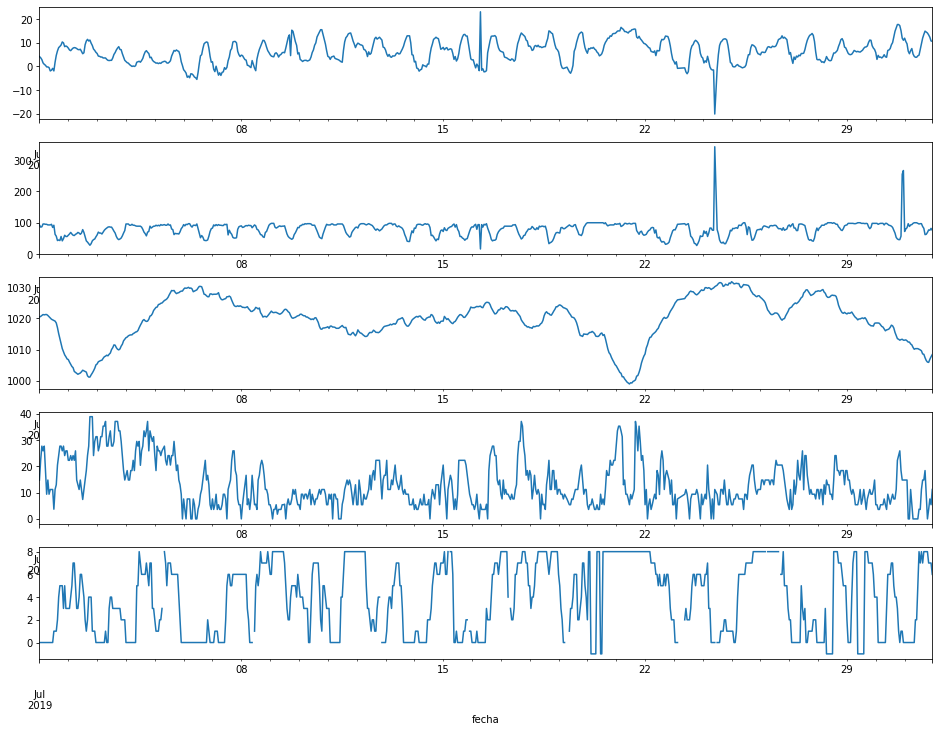

In [312]:
f, ax = plt.subplots(len(exog_julio.columns), 1, figsize=(16,12))
for k,col in enumerate(exog_julio.columns):
    exog_julio[col].plot(ax=ax[k])

In [313]:
exog_julio["dia"] = exog_julio.index.day
exog_julio["hora"] = exog_julio.index.hour

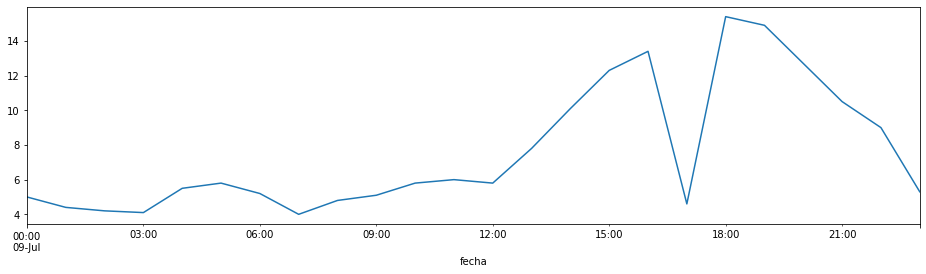

In [314]:
exog_julio.loc[exog_julio.dia == 9, "temp"].plot()

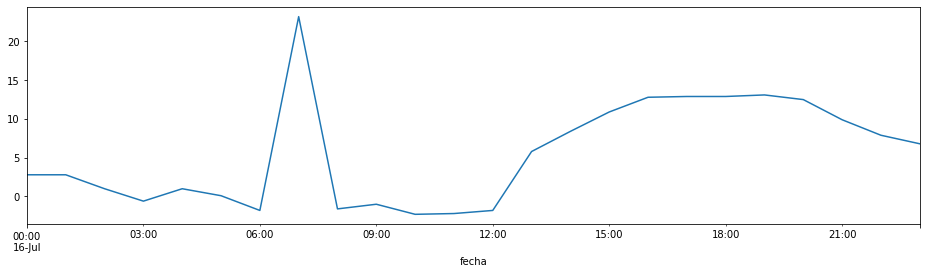

In [315]:
exog_julio.loc[exog_julio.dia == 16, "temp"].plot()

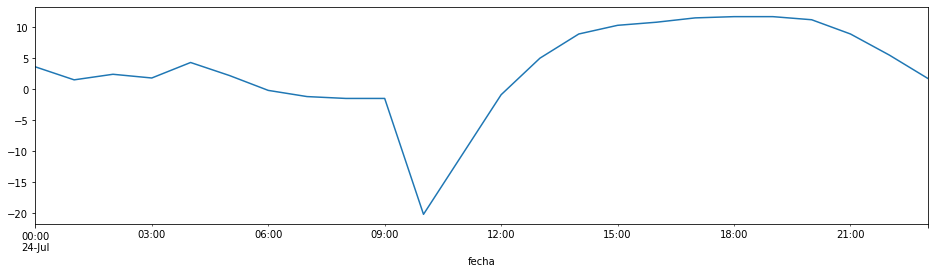

In [316]:
exog_julio.loc[exog_julio.dia == 24, "temp"].plot()

In [317]:
exog_julio.loc[(exog_julio.dia == 9) & (exog_julio.hora == 17), "temp"] = np.nan
exog_julio.loc[(exog_julio.dia == 16) & (exog_julio.hora == 7), "temp"] = np.nan
exog_julio.loc[(exog_julio.dia == 24) & (exog_julio.hora == 10), "temp"] = np.nan
exog_julio.loc[(exog_julio.dia == 24) & (exog_julio.hora == 11), "temp"] = np.nan

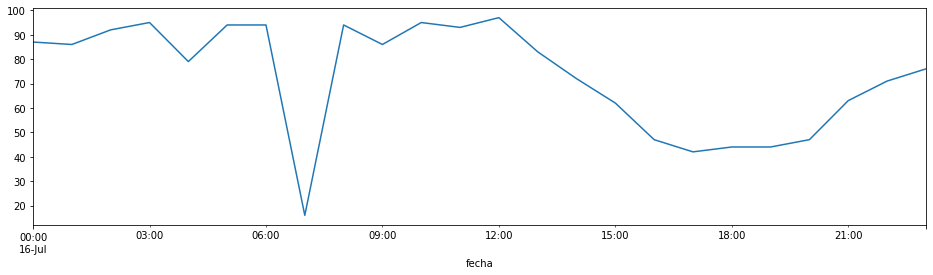

In [318]:
exog_julio.loc[exog_julio.dia == 16, "hum"].plot()

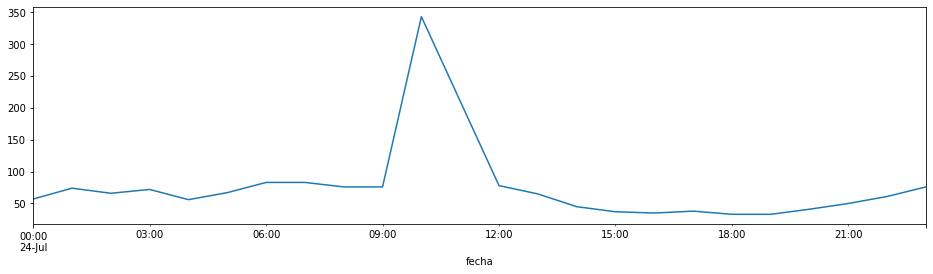

In [319]:
exog_julio.loc[exog_julio.dia == 24, "hum"].plot()

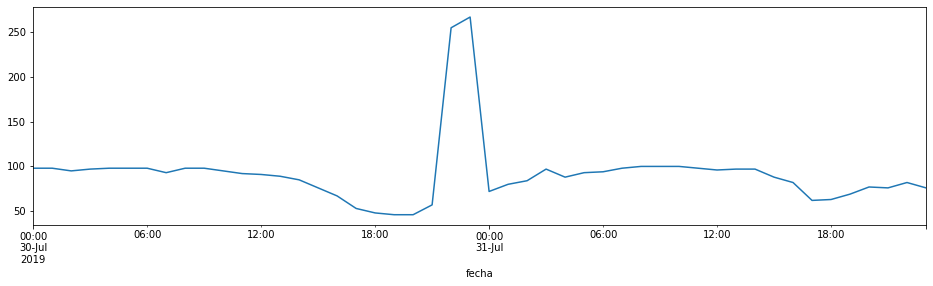

In [320]:
exog_julio.loc[exog_julio.dia.isin([30,31]), "hum"].plot()

In [321]:
exog_julio.loc[(exog_julio.dia == 16) & (exog_julio.hora == 7), "hum"] = np.nan
exog_julio.loc[(exog_julio.dia == 24) & (exog_julio.hora == 10), "hum"] = np.nan
exog_julio.loc[(exog_julio.dia == 24) & (exog_julio.hora == 11), "hum"] = np.nan
exog_julio.loc[(exog_julio.dia == 30) & (exog_julio.hora == 22), "hum"] = np.nan
exog_julio.loc[(exog_julio.dia == 30) & (exog_julio.hora == 23), "hum"] = np.nan

In [322]:
values = exog_julio.loc[:, ["temp", "hum", "presion", "vel"]].interpolate(method="linear")
exog_julio.loc[:, ["temp", "hum", "presion", "vel"]] = values

In [323]:
exog_julio.nub = exog_julio.nub.fillna(method="ffill")

In [324]:
exog_julio.isna().sum()

temp       0
hum        0
presion    0
vel        0
nub        0
dia        0
hora       0
dtype: int64

In [325]:
exog_julio = exog_julio.drop(columns=["dia", "hora"])

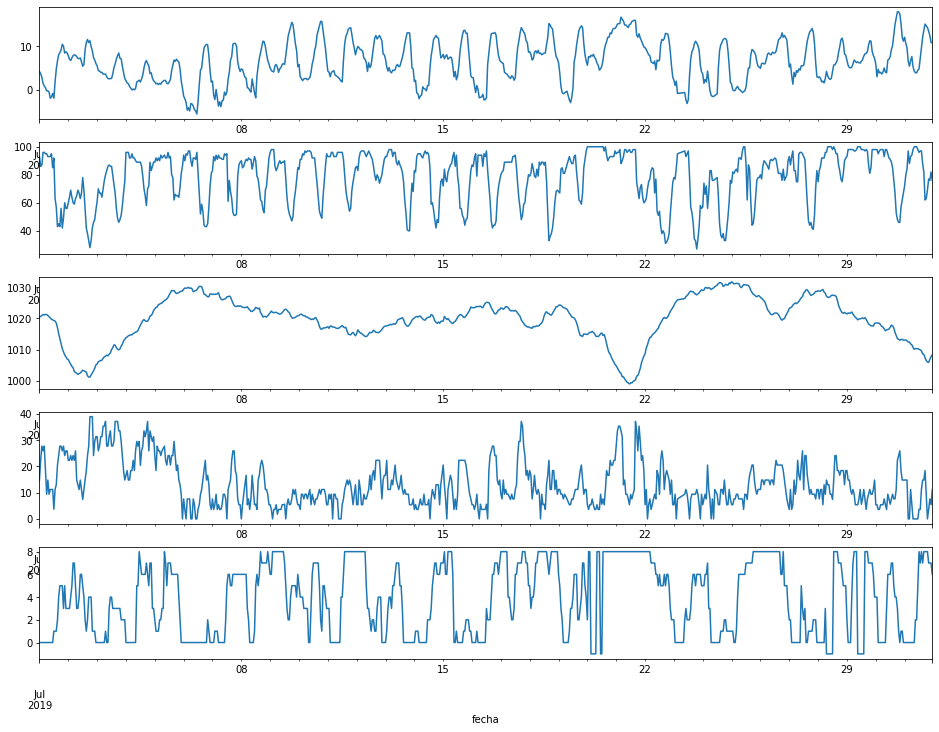

In [326]:
cols = exog_julio.columns
f, ax = plt.subplots(len(cols), 1, figsize=(16,12))
for k,col in enumerate(cols):
    exog_julio[col].plot(ax=ax[k])

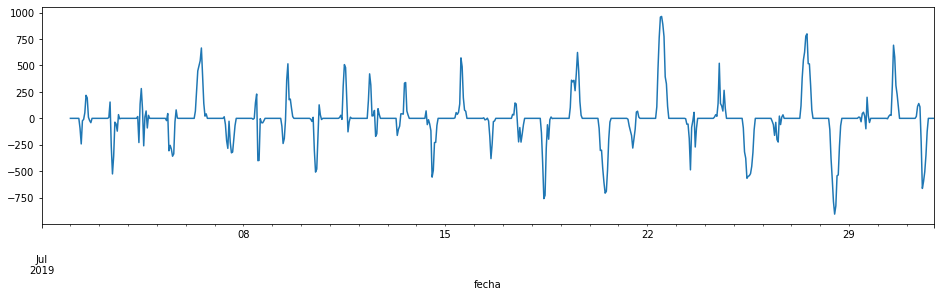

In [327]:
pot_julio.diff(periods=24).plot()

In [330]:
fit_autoarima = pmd.auto_arima(pot_julio, exogenous=, seasonal=True, m=24, d=0, D=1, trace=True, suppress_warnings=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 24); AIC=8312.047, BIC=8348.681, Fit time=39.634 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=9660.005, BIC=9669.164, Fit time=0.226 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=8569.482, BIC=8587.799, Fit time=10.196 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=8670.299, BIC=8688.616, Fit time=10.050 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 24); AIC=8320.721, BIC=8352.776, Fit time=28.234 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 1, 24); AIC=8321.153, BIC=8362.366, Fit time=99.232 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 0, 24); AIC=8503.456, BIC=8535.511, Fit time=20.694 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 2, 24); AIC=8313.077, BIC=8354.291, Fit time=117.715 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 0, 24); AIC=8705.725, BIC=8733.200, Fit time=11.805 seconds
Fit ARIMA: order=(2

In [125]:
exog_forecast = data_hourly.loc["2019-08-01":"2019-08-07", ["temp", "hum", "presion", "vel", "nub"]]

In [126]:
exog_forecast.isna().sum()

temp       0
hum        0
presion    0
vel        0
nub        1
dtype: int64

In [128]:
exog_forecast = exog_forecast.fillna(method="ffill")

In [331]:
forecast = fit_autoarima.predict(n_periods=24*7,)#exogenous=exog_forecast)

In [332]:
forecast = pd.Series(forecast, index=exog_forecast.index)

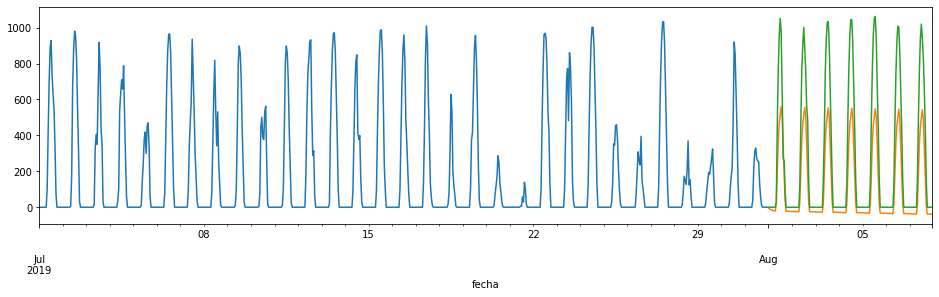

In [333]:
pot_julio.plot()
forecast.plot()
pot_test.plot()

In [135]:
in_sample = fit_autoarima.predict_in_sample(exogenous=exog_julio, start=0, end=743)

In [136]:
in_sample  = pd.Series(in_sample, index=exog_julio.index)

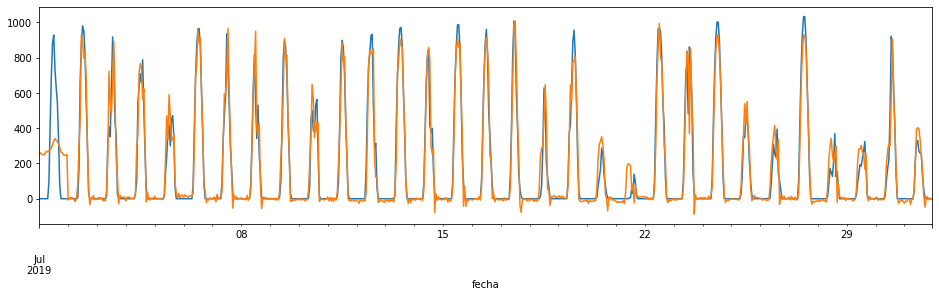

In [138]:
pot_julio.plot()
in_sample.plot()

In [367]:
df = pd.DataFrame(pot_julio)

In [368]:
df = df.reset_index()

In [369]:
df = df.rename(columns={"fecha":"ds", "pot":"y"})

In [370]:
df2 = exog_julio.reset_index().drop(columns=["fecha"])
df2.head()

,temp,hum,presion,vel,nub
0,4.2,93.0,1020.4,14.8,0.0
1,3.7,86.0,1020.6,22.3,0.0
2,2.9,87.0,1020.9,27.7,0.0
3,1.5,96.0,1021.2,25.9,0.0
4,0.9,96.0,1021.1,27.7,0.0


In [371]:
df = df.join(df2)

In [372]:
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False)

In [373]:
#model_prophet.add_regressor("temp")
#model_prophet.add_regressor("hum")
#model_prophet.add_regressor("presion")
#model_prophet.add_regressor("vel")
#model_prophet.add_regressor("nub")

In [374]:
model_prophet.fit(df)

In [375]:
future = model_prophet.make_future_dataframe(24*7, freq="H", include_history=False)

In [360]:
exog_future = exog_forecast.reset_index().drop(columns=["fecha"])

In [361]:
future = future.join(exog_future)

In [362]:
future.isna().sum()

ds         0
temp       0
hum        0
presion    0
vel        0
nub        0
dtype: int64

In [376]:
forecast = model_prophet.predict(future)

In [377]:
yhat = forecast[["ds", "yhat"]]

In [378]:
yhat = yhat.set_index("ds")

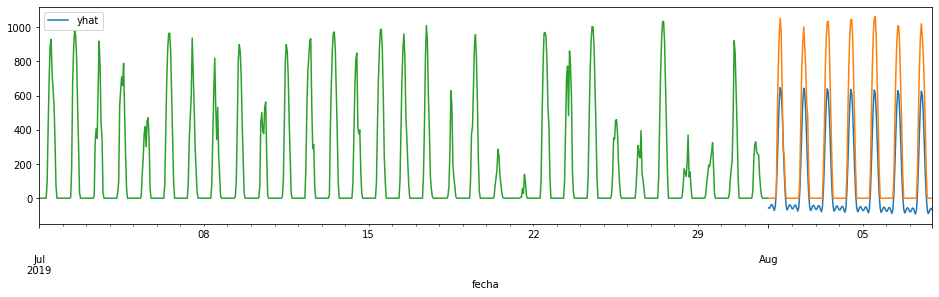

In [379]:
yhat.plot()
pot_test.plot()
pot_julio.plot()

In [199]:
model_tbats = TBATS(seasonal_periods=[24])

In [ ]:
model_tbats.fit()

In [ ]:
data_april = data_hourly.loc["2019-04-01":"2019-04-30"].copy()

In [ ]:
data_may = data_hourly.loc["2019-05-01":"2019-05-31"].copy()

In [ ]:
data_april.head()

In [ ]:
endog = ["temp"]
exog = ["hum", "presion", "vel", "nub"]

In [ ]:
columns = ["temp", "hum", "presion", "vel"]
f, ax = plt.subplots(4, 1, figsize=(12,16))
for k in range(len(ax)):
    data_april[columns[k]].plot(ax=ax[k])

In [ ]:
columns = ["temp", "hum", "presion", "vel"]
f, ax = plt.subplots(4, 1, figsize=(12,16))
for k in range(len(ax)):
    data_may[columns[k]].plot(ax=ax[k])

In [ ]:
data_may.vel.plot(xlim=("2019-05-25", "2019-05-27"))

In [ ]:
data_may.loc["2019-05-25 12:00:00", "vel"] = np.nan

In [ ]:
data_may.vel = data_may.vel.interpolate(kind="linear")

In [ ]:
conc = pd.concat([data_april, data_may])

In [ ]:
train, test = conc.loc[:"2019-05-24", :], conc.loc["2019-05-25":, :]

In [ ]:
endog = ["temp"]
exog = ["hum", "presion", "vel"]

In [ ]:
sarima_model = SARIMAX(endog=train[endog], exog=train[exog], order=(3,1,0), seasonal_order=(0,1,2,24))
sarima_fit = sarima_model.fit()

In [ ]:
autoarima_fit = pmd.auto_arima(train[endog], exogenous=train[exog], seasonal=True, d=1, D=1, m=24, suppress_warnings=True, trace=True)

In [ ]:
autoarima_fit.summary()

In [ ]:
sarima_fit.summary()

In [ ]:
forecast = autoarima_fit.predict(n_periods=7*24, exogenous=test[["hum", "presion", "vel"]])
forecast = pd.Series(forecast, index=test.index)
#train.temp.plot()
test.temp.plot()
forecast.plot()

In [ ]:
forecast = sarima_fit.forecast(steps=7*24, exog=test[exog])
forecast = pd.Series(forecast, index=test.index)
#train.temp.plot()
test.temp.plot()
forecast.plot()

In [ ]:
df.head()

In [ ]:
df = pd.DataFrame(train.temp)
df = df.reset_index()
df = df.rename(columns = {"fecha":"ds", "temp":"y"})
df.head()

In [ ]:
m = Prophet(weekly_seasonality=False, yearly_seasonality=False)
m.fit(df)

In [ ]:
future = m.make_future_dataframe(periods=7*24, freq="H")

future.tail()

In [ ]:
forecast = m.predict(future)

In [ ]:
forecast[["ds", "yhat", "yhat_lower", "yhat_upper", ]].tail()

In [ ]:
pred = forecast.set_index("ds")["yhat"]

In [ ]:
pd.plotting.register_matplotlib_converters()

In [ ]:
#train.temp.plot()
test.temp.plot()
pred.asfreq("H").plot(xlim=("2019-05-24","2019-05-31"))


In [ ]:
tbats_model = TBATS(seasonal_periods=[24])

In [ ]:
tbats_fit = tbats_model.fit(train.temp)

In [ ]:
forecast = pd.Series(tbats_fit.forecast(steps=7*24), index=test.index)

In [ ]:
train.temp.plot()
test.temp.plot()
forecast.plot()

In [ ]:
m.plot(forecast)

In [ ]:
train.presion.plot()

A continuación vamos a extraer las temperaturas del mes de abril y vamos a tratar de hacer un pronóstico utilizando ARIMA estacional.

In [ ]:
april = temp.loc["2019-04-01":"2019-04-30"]
april.plot()

Se ve claramente la estacionalidad diaria, por lo que ahora tomamos diferencias pero con un período de 24 horas.

In [ ]:
april_s = april.diff(periods=24).dropna()
april_s.plot(figsize=fs)

Los datos no parecen estacionarios, así que también tomamos la primer diferencia.

In [ ]:
april_ds = april_s.diff(periods=1).dropna()
april_ds.plot(figsize=fs)

Los datos parecen ser ruido blanco. Aplicamos el test kpss para estar un poco más seguros de que la serie es estacionaria.

In [ ]:
tsa.kpss(april_ds)

El p-valor es mayor a 0.1 y el valor del estadístico es pequeño, por lo que no podemos descartar la hipótesis nula de estacionariedad.

Ahora consideramos las gráficas de autocorrelación completa y parcial para los primeros 4 días.

In [ ]:
plot_acf(april_ds, lags=4*24);
plt.ylim((-0.5, 0.5))
plot_pacf(april_ds, lags=4*24);
plt.ylim((-0.5, 0.5))

Las gráficas no son concluyentes para elegir los valores apropiados de p y q para la parte no estacional, podría ser p=12, q=12, o alguna combinación. Por otra parte, para el orden estacional parece que los valores p=0 y q=1 son un buen punto de partida.

A continuación dividimos los datos en entrenamiento y prueba preparamos el modelo.

In [ ]:
train, test = april.loc[:"2019-04-21"], april.loc["2019-04-21":]

In [ ]:
model_sarima = SARIMAX(train, order=(12,1,0), seasonal_order=(0,1,2,24))
fit_sarima = model_sarima.fit()

In [ ]:
#train.plot()
april.plot()
fit_sarima.predict(start="2019-04-01", end="2019-05-01").plot(figsize=fs)

In [ ]:
residuals = fit_sarima.resid

plot_acf(residuals, lags=4*24)
plt.ylim((-0.5, 0.5))
plot_pacf(residuals, lags=4*24)
plt.ylim((-0.5, 0.5))

In [ ]:
stepwise_fit = pm.auto_arima(april, max_p=12, max_q=12, max_P=2, max_Q=2, d=1, m=24, seasonal=True,
                             trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

In [ ]:
pm.auto_arima?